In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

In [3]:
def preprocess_data(path):
    data = pd.read_csv(path)
    X = data.iloc[:, 0:29].values
    y = data.iloc[:, 29].values
    return X, y

In [4]:
def compute_eigens(data):
    cov_matrix = np.cov(data.T)
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix)
    return eigen_val, eigen_vec

In [30]:
def project(data):
    eigen_val, eigen_vec = compute_eigens(data)
    eigen_pairs = {}
    for i in range(0, len(eigen_val)):
        eigen_pairs[eigen_val[i]] = eigen_vec[:, i]
        
    new_axes = []
    count = 1
    for key in eigen_pairs:
        new_axes.append(eigen_pairs[key])
        projected_data = data.dot(np.array(new_axes).T)
        reconstructed_data = projected_data.dot(np.array(new_axes))
        loss = ((data - reconstructed_data) ** 2).mean() * 100
        if(loss < 10.00):
            return count, loss, projected_data
        count += 1

In [31]:
def PCA(data):
    count, loss, projected_data = project(data)
    print ("Number Of Dimensions After Reduction \t: ", count)
    print ("Reconstruction Accuracy (in %) \t\t: ", 100 - loss)
    print ("Reconstruction Loss (in %) \t\t: ", loss)
    return projected_data

In [32]:
def plot_clusters(data, centers):
    fig, ax = plt.subplots(figsize = (16,8))
    ax.scatter(data[:, 0], data[:,1], s=7)
    ax.scatter(centers[:,0], centers[:,1], marker='*', c='y', s=150)

In [33]:
def k_means(data, k):
    n = data.shape[0]
    c = data.shape[1]
    data_mean = np.mean(data, axis = 0)
    data_std = np.std(data, axis = 0)
    initial_centers = data[0:5, :]

    old_centers = np.zeros(initial_centers.shape)
    new_centers = deepcopy(initial_centers)

    clusters = np.zeros(n)
    distances = np.zeros((n,k))

    error = np.linalg.norm(new_centers - old_centers)

    while error != 0:
        for i in range(k):
            distances[:,i] = np.linalg.norm(data - initial_centers[i], axis=1)
        clusters = np.argmin(distances, axis = 1)

        old_centers = deepcopy(new_centers)
        for i in range(k):
            new_centers[i] = np.mean(data[clusters == i], axis=0)
        error = np.linalg.norm(new_centers - old_centers)
           
    return clusters, new_centers

In [34]:
def purity(data, cluster, output):
    result = pd.DataFrame(data)
    output = pd.DataFrame(output, columns = {"xAttack"})
    result = pd.concat([result, output], axis = 1)
    True_Evaluated_Data = 0
    Total_Data  = len(result)
    actual_matrix = pd.Series(cluster, name='Clusters')
    prediction_matrix = pd.Series(result.iloc[:,-1], name='Classes')
    df_confusion = pd.crosstab(prediction_matrix, actual_matrix)
    print(tabulate(df_confusion, headers='keys', tablefmt='psql'))
    max_vals = np.array([df_confusion.max()])
    purity = max_vals.sum()/len(result)
    print ("Purity =",purity * 100)
    return df_confusion

In [35]:
def matrix_purity(matrix, data):
    max_vals = np.array([matrix.max()])
    purity = max_vals.sum()/len(data)
    print (purity*100)

In [36]:
def gmm_predict(data, output, gmm_model):
    pred_clusters = gmm_model.predict(data)
    cluster_series = pd.Series(pred_clusters, name='Clusters')
    label_series = pd.Series(output, name='Classes')
    matrix = pd.crosstab(label_series, cluster_series, margins=True)
    matrix = matrix.iloc[:-1, :-1]
    print(tabulate(matrix, headers='keys', tablefmt='psql'))
    return matrix

In [37]:
def gmm(data):
    gmm_model = GaussianMixture(n_components=5, random_state=3)
    clf = gmm_model.fit(data)
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(data[:,0], data[:,1])
    for i in range(5):
        ax.scatter(gmm_model.means_[i,0], gmm_model.means_[i,1], marker='*', c='yellow', s=150)
    plt.show()
    return gmm_model

In [38]:
def agglo_clustering(data):
    cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
    cluster.fit_predict(data)  
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(data[:,0], data[:,1], c=cluster.labels_, cmap='rainbow')  
    return cluster

In [39]:
def main():
    X, y = preprocess_data("../input/data.csv")
    X_normalized = StandardScaler().fit_transform(X)
    projected_data = PCA(X_normalized)
    k = 5
    clusters, centers = k_means(projected_data, k)
    return projected_data, clusters, centers, y

# REPORT

# <font color = "blue">PART 1:</font>
## <font color = "blue">Reduced Dimensions And Tolerance Value</font>

In [40]:
data, clusters, centers, output = main()

Number Of Dimensions After Reduction 	:  14
Reconstruction Accuracy (in %) 		:  90.93190252147994
Reconstruction Loss (in %) 		:  9.068097478520054


# <font color = "blue">PART 2:</font>
## <font color = "blue">Data Spread With Initial Cluster Centers</font>

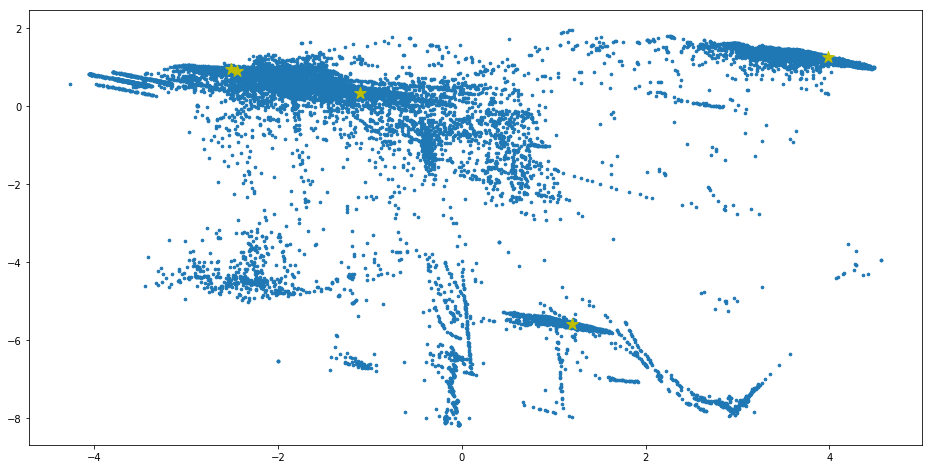

In [41]:
initial_centers = data[0:5, :]
plot_clusters(data, initial_centers)

## <font color = "blue">Data Spread With Final Cluster Centers</font>

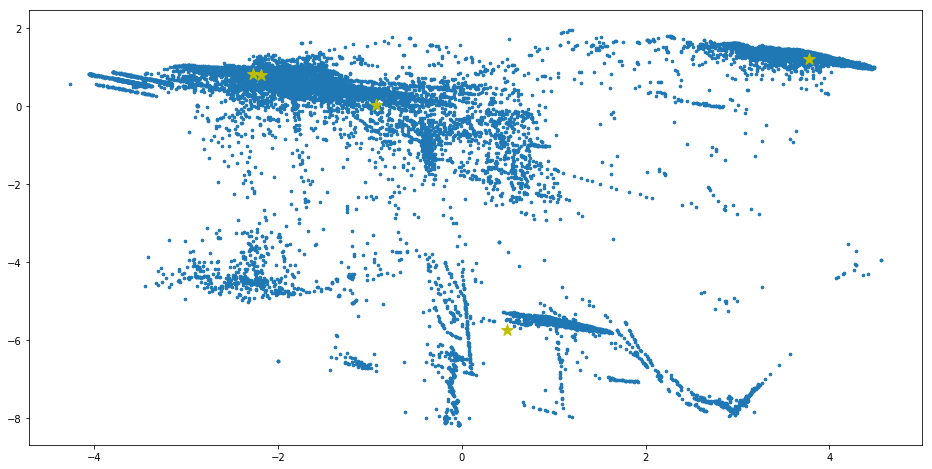

In [42]:
plot_clusters(data, centers)

## <font color= "blue">Purity Of Clusters With Tabular Representation</font>

In [43]:
matrix = purity(data, clusters, output)

+-----------+------+------+------+------+------+
| Classes   |    0 |    1 |    2 |    3 |    4 |
|-----------+------+------+------+------+------|
| dos       |   54 | 1364 |   67 |  839 | 6790 |
| normal    | 6189 |  508 | 2944 | 3704 |   19 |
| probe     |  801 | 1041 |    0 |  405 |   66 |
| r2l       |    3 |   10 |    4 |  180 |    0 |
| u2r       |    0 |    0 |    0 |   10 |    0 |
+-----------+------+------+------+------+------+
Purity = 83.97071765741259


## <font color = "blue"> Pie Charts For Each Cluster(K Means)</font>

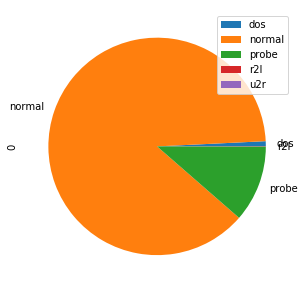

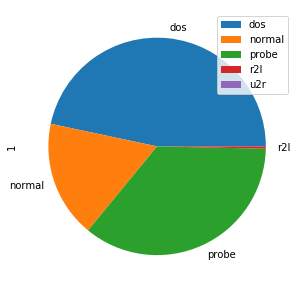

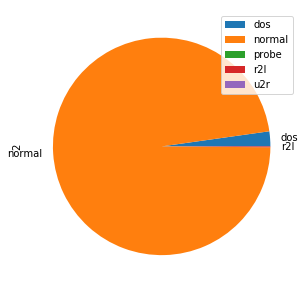

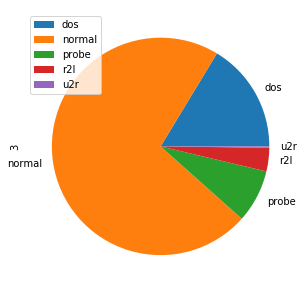

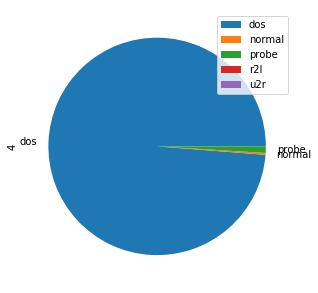

In [44]:
for i in range(0,5):
    plot = matrix.plot.pie(y= i, figsize=(5, 5))

## <font color = "blue">PART 3:</font>
## <font color = "blue">CLUSTERING USING GMM</font>

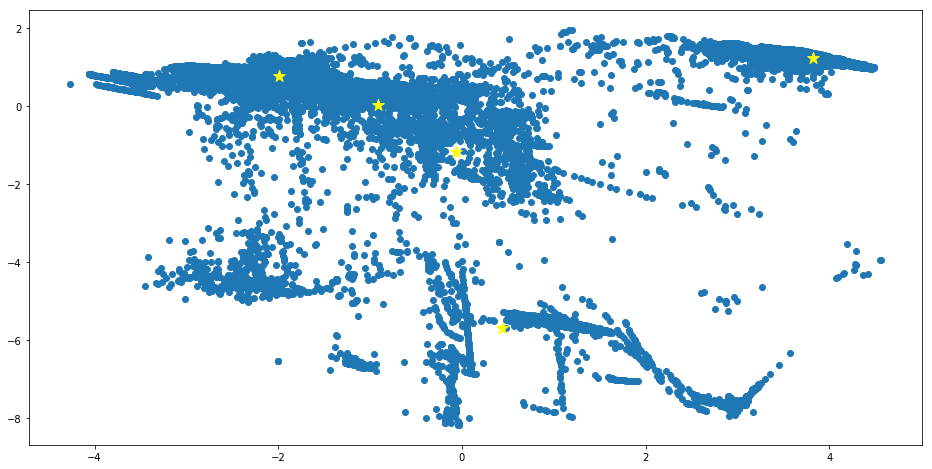

In [20]:
gmm_model = gmm(data)

## <font color = "blue">Predictions Using GMM Clustering</font>

In [21]:
matrix = gmm_predict(data, output, gmm_model)

+-----------+------+-------+------+------+-----+
| Classes   |    0 |     1 |    2 |    3 |   4 |
|-----------+------+-------+------+------+-----|
| dos       | 1364 |   598 |  634 | 6518 |   0 |
| normal    |  551 | 10121 | 2680 |    0 |  12 |
| probe     | 1035 |   356 |  921 |    0 |   1 |
| r2l       |    1 |    93 |  102 |    0 |   1 |
| u2r       |    0 |     3 |    7 |    0 |   0 |
+-----------+------+-------+------+------+-----+


## <font color = "blue">Clustering Purity</font>

In [22]:
matrix_purity(matrix, data)

82.78662292983438


## <font color = "blue"> Pie Charts For Each Cluster(GMM)</font>

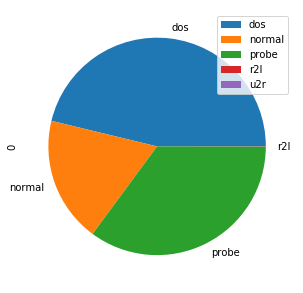

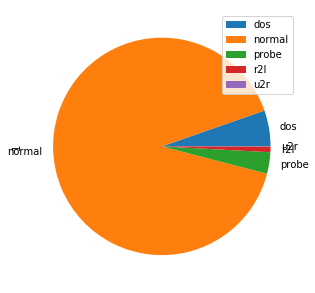

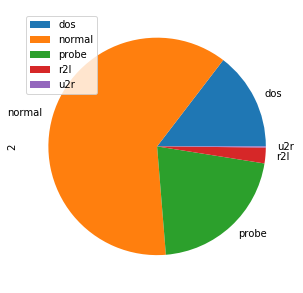

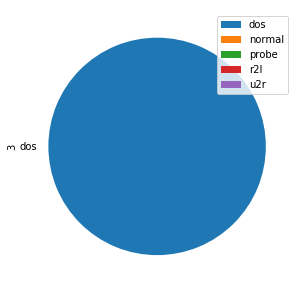

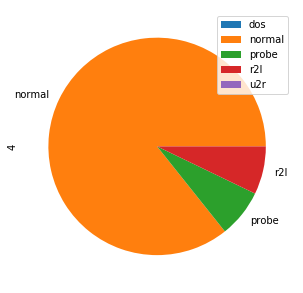

In [23]:
for i in range(0,5):
    plot = matrix.plot.pie(y= i, figsize=(5, 5))

# <font color = "blue">PART 4:</font>
## <font color = "blue">Agglomerative Clustering</font>

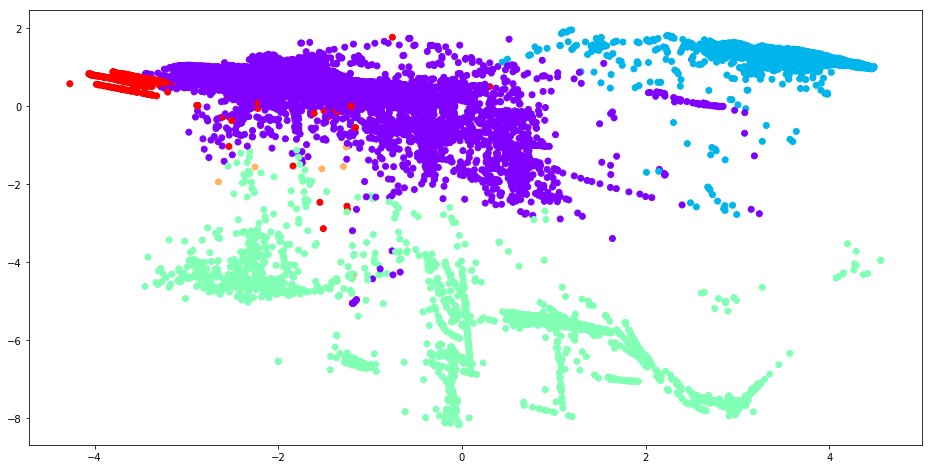

In [24]:
cluster = agglo_clustering(data)

In [28]:
cluster_series = pd.Series(cluster.labels_, name='Clusters')
label_series = pd.Series(output, name='Classes')
hc_confusion_df = pd.crosstab(label_series, cluster_series, margins=True)
hc_confusion_df = hc_confusion_df.iloc[:-1, :-1]
print(tabulate(hc_confusion_df, headers='keys', tablefmt='psql'))

+-----------+-------+------+------+-----+-----+
| Classes   |     0 |    1 |    2 |   3 |   4 |
|-----------+-------+------+------+-----+-----|
| dos       |   941 | 6805 | 1368 |   0 |   0 |
| normal    | 12724 |   20 |  578 |   8 |  34 |
| probe     |   481 |   29 | 1052 |   0 | 751 |
| r2l       |   197 |    0 |    0 |   0 |   0 |
| u2r       |    10 |    0 |    0 |   0 |   0 |
+-----------+-------+------+------+-----+-----+


## <font color = "blue">Pie Chart For Each Cluster(Agglomerative Clustering)</font>

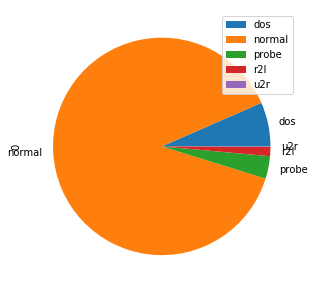

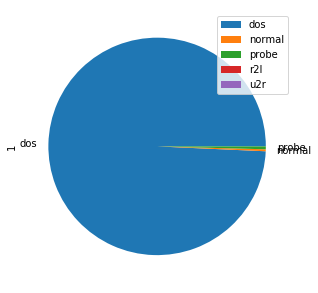

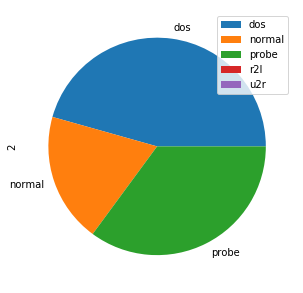

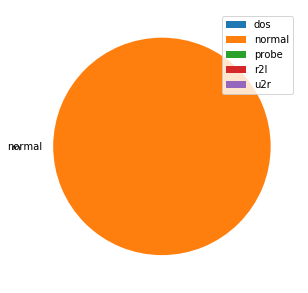

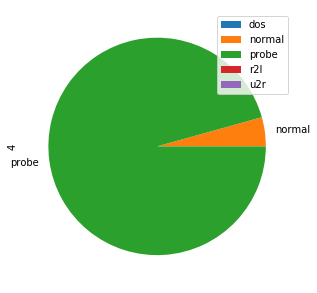

In [29]:
for i in range(0,5):
    plot = hc_confusion_df.plot.pie(y= i, figsize=(5, 5))

## <font color = "blue">Dendrogram Plot(takes a lot of time to plot)</font>

In [26]:
# plt.figure(figsize=(16, 8))  
# plt.title("Dendograms")  
# dend = shc.dendrogram(shc.linkage(data, method='ward'))  

# <font color = "blue">PART 5 : USE OF PCA</font>

## Question : If you were to do dimensionality reduction on original data, could you use PCA?

<font color =  "blue">If our goal is solely dimension reduction, then PCA is the way to go, we generally regard PCA on mixtures of variables with less than enthusiasm. Doing regular PCA on the raw variables is not recommended. We should first create a distance matrix and then operate on that.</font>
<font color =  "blue">Make distance matrix using gower’s distance . In R it can be done by : - library(cluster); dist <- daisy(college.data,metric = $"gower"$)
Then we can use this distance matrix to reduce dimension.
But I will recommend this method only if we have small data-set of less than 7000 rows. Let say if we have data-set of 100,000 rows , then it’s better to do one good encoding and then PCA or MULTIPLE CORRESPONDENCE ANALYSIS (MCA) rather than distance matrix because size of distance matrix will be (100,000 X 100,000), which will take forever for PCA to operate on.</font>